In [1]:
import pandas as pd
from glob import glob
from re import match
from missingno import matrix as mmatrix
from matplotlib import pyplot as plt
import seaborn as sns
from math import ceil

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [2]:
CSVs = glob('data/*/*.csv')

for csv in CSVs:
    csv = csv.replace('\\', '/')
    file = match(r'data.*/(.*?)\.csv', csv).group(1)
    print(file)
    exec(f'{file} = pd.read_csv("{csv}")')
    exec(f'{file}["state"] = "{file.split('_')[-1].upper()}"')


forecastdemand_qld
forecastdemand_sa
forecastdemand_vic
temprature_qld
temprature_sa
temprature_vic
totaldemand_qld
totaldemand_sa
totaldemand_vic
forecastdemand_nsw
temperature_nsw
totaldemand_nsw


In [3]:
dem = pd.concat([totaldemand_qld, totaldemand_sa, totaldemand_vic])

dem.DATETIME = pd.to_datetime(dem.DATETIME, format="%Y-%m-%d %H:%M:%S")
totaldemand_nsw.DATETIME = pd.to_datetime(totaldemand_nsw.DATETIME, format="%d/%m/%Y %H:%M")
dem = pd.concat([dem, totaldemand_nsw]).reset_index(drop=True)\
    .drop(columns=['REGIONID'])

print(dem.isnull().sum())

dem


DATETIME       0
TOTALDEMAND    0
state          0
dtype: int64


,DATETIME,TOTALDEMAND,state
0,2010-01-01 00:00:00,5561.21,QLD
1,2010-01-01 00:30:00,5422.25,QLD
2,2010-01-01 01:00:00,5315.98,QLD
3,2010-01-01 01:30:00,5186.70,QLD
4,2010-01-01 02:00:00,5050.83,QLD
...,...,...,...
786046,2021-03-17 22:00:00,7419.77,NSW
786047,2021-03-17 22:30:00,7417.91,NSW
786048,2021-03-17 23:00:00,7287.32,NSW
786049,2021-03-17 23:30:00,7172.39,NSW


In [4]:
fore = pd.concat([
    forecastdemand_qld, forecastdemand_sa, forecastdemand_vic, forecastdemand_nsw
]).drop(columns=['REGIONID'])

for col in ["LASTCHANGED", "DATETIME"]:
    fore[col] = pd.to_datetime(fore[col], format="%Y-%m-%d %H:%M:%S")

print(fore.isnull().sum())

fore


PREDISPATCHSEQNO    0
PERIODID            0
FORECASTDEMAND      0
LASTCHANGED         0
DATETIME            0
state               0
dtype: int64


,PREDISPATCHSEQNO,PERIODID,FORECASTDEMAND,LASTCHANGED,DATETIME,state
0,2016123018,71,6425.36,2016-12-30 12:31:25,2017-01-01 00:00:00,QLD
1,2016123018,72,6193.34,2016-12-30 12:31:25,2017-01-01 00:30:00,QLD
2,2016123018,73,6016.45,2016-12-30 12:31:25,2017-01-01 01:00:00,QLD
3,2016123018,74,5859.23,2016-12-30 12:31:25,2017-01-01 01:30:00,QLD
4,2016123018,75,5767.15,2016-12-30 12:31:25,2017-01-01 02:00:00,QLD
...,...,...,...,...,...,...
10906014,2021031736,5,7028.45,2021-03-17 21:31:31,2021-03-18 00:00:00,NSW
10906015,2021031737,4,7041.65,2021-03-17 22:01:34,2021-03-18 00:00:00,NSW
10906016,2021031738,3,7087.60,2021-03-17 22:31:36,2021-03-18 00:00:00,NSW
10906017,2021031739,2,7087.28,2021-03-17 23:01:36,2021-03-18 00:00:00,NSW


In [5]:
temp = pd.concat([temprature_qld, temperature_nsw, temprature_vic])
temp.DATETIME = pd.to_datetime(temp.DATETIME, format="%d/%m/%Y %H:%M")

temprature_sa.DATETIME = pd.to_datetime(temprature_sa.DATETIME, format="%Y-%m-%d %H:%M:%S")
temp = pd.concat([temp, temprature_sa])\
    .drop(columns = ['Unnamed: 0', 'LOCATION']).reset_index(drop=True)

print(temp.isnull().sum())

temp


DATETIME       0
TEMPERATURE    0
state          0
dtype: int64


,DATETIME,TEMPERATURE,state
0,2010-01-01 00:00:00,23.6,QLD
1,2010-01-01 00:30:00,23.7,QLD
2,2010-01-01 01:00:00,23.5,QLD
3,2010-01-01 01:30:00,22.6,QLD
4,2010-01-01 02:00:00,22.0,QLD
...,...,...,...
778172,2021-03-17 22:00:00,19.6,SA
778173,2021-03-17 22:30:00,19.5,SA
778174,2021-03-17 23:00:00,19.4,SA
778175,2021-03-17 23:30:00,19.6,SA


In [65]:
df = pd.merge(temp, dem, on=['DATETIME', 'state'], how='outer')\
    .dropna().reset_index(drop=True)

# mmatrix(df.sort_values('DATETIME'))

ohe = OneHotEncoder(sparse_output=False)
df[sorted(df.state.unique())] = ohe.fit_transform(df.state.to_numpy().reshape(-1, 1))
# df = df.drop(columns=['state'])

df


,DATETIME,TEMPERATURE,state,TOTALDEMAND,NSW,QLD,SA,VIC
0,2010-01-01 00:00:00,23.6,QLD,5561.21,0.0,1.0,0.0,0.0
1,2010-01-01 00:30:00,23.7,QLD,5422.25,0.0,1.0,0.0,0.0
2,2010-01-01 01:00:00,23.5,QLD,5315.98,0.0,1.0,0.0,0.0
3,2010-01-01 01:30:00,22.6,QLD,5186.70,0.0,1.0,0.0,0.0
4,2010-01-01 02:00:00,22.0,QLD,5050.83,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...
723997,2021-03-17 22:00:00,19.6,SA,1277.91,0.0,0.0,1.0,0.0
723998,2021-03-17 22:30:00,19.5,SA,1226.81,0.0,0.0,1.0,0.0
723999,2021-03-17 23:00:00,19.4,SA,1202.62,0.0,0.0,1.0,0.0
724000,2021-03-17 23:30:00,19.6,SA,1194.34,0.0,0.0,1.0,0.0


In [64]:
X_train, X_test, y_train, y_test = train_test_split(
    df.dropna().drop(columns=['TOTALDEMAND', 'DATETIME']), df.dropna().TOTALDEMAND, 
    test_size=0.4, random_state=1
)

X_train


,TEMPERATURE,NSW,QLD,SA,VIC
153941,19.6,0.0,1.0,0.0,0.0
267052,26.2,1.0,0.0,0.0,0.0
165569,14.1,0.0,1.0,0.0,0.0
480768,5.7,0.0,0.0,0.0,1.0
134485,24.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...
371403,23.2,1.0,0.0,0.0,0.0
491263,24.7,0.0,0.0,0.0,1.0
470924,12.8,0.0,0.0,0.0,1.0
491755,16.5,0.0,0.0,0.0,1.0


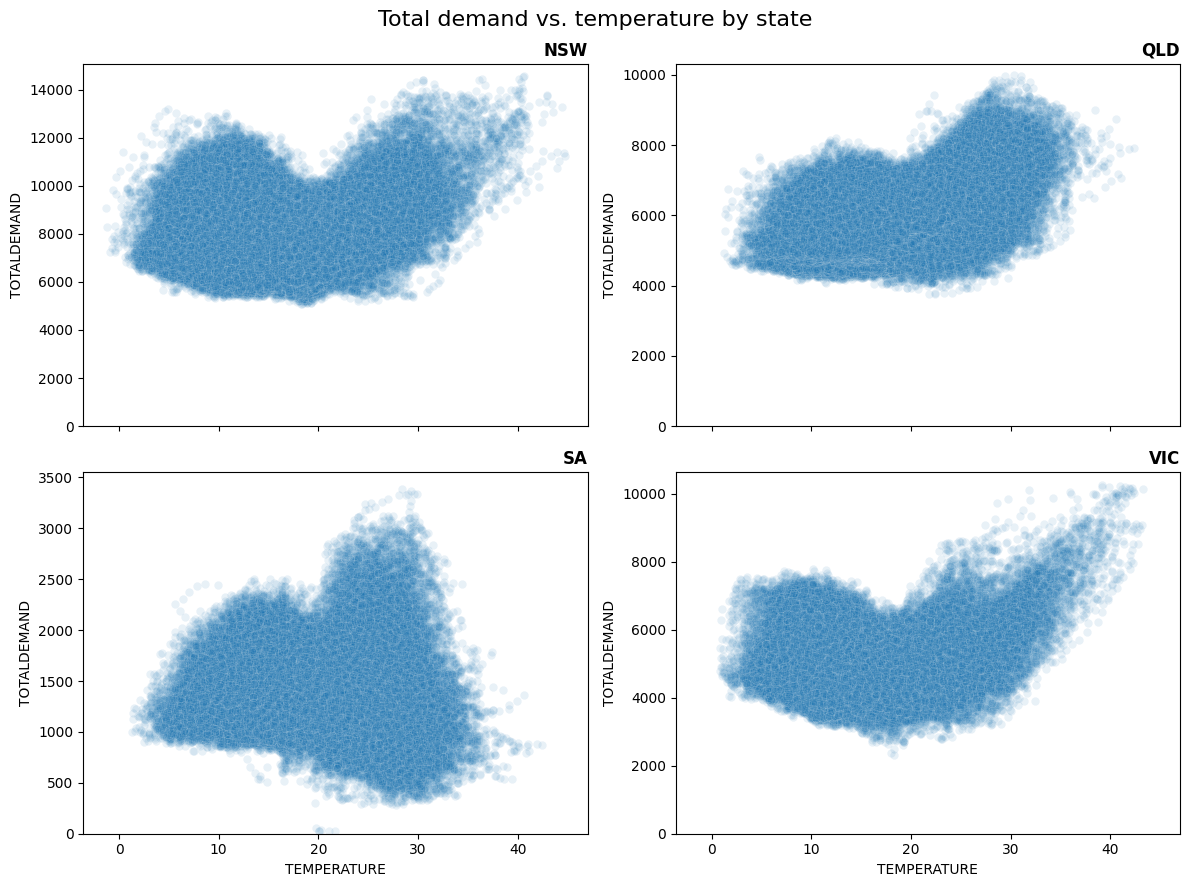

In [157]:
states = sorted(df.state.unique())
n, n_cols = len(states), 2
n_rows = ceil(n / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_rows, 9), sharex=True)
axes = axes.flatten()

for i, state in enumerate(states):
    ax = axes[i]
    sns.scatterplot(
        y='TOTALDEMAND', x='TEMPERATURE', ax=ax, data=df[df.state == state],#.sample(1000), 
        alpha=0.1
    )
    ax.set_title(state, loc ='right', fontweight=600)
    ax.set_ylim(0)

plt.suptitle('Total demand vs. temperature by state', fontsize=16)
plt.tight_layout()

plt.show()


In [156]:

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

mlp = MLPRegressor(hidden_layer_sizes=(10, 10, 10), max_iter=1000, random_state=1)
mlp.fit(X=X_train_scaled, y=y_train)
y_pred = mlp.predict(X_test_scaled)

mlp


MLPRegressor(hidden_layer_sizes=(10, 10, 10), max_iter=1000, random_state=1)

In [98]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")


Mean Squared Error: 697775.4238389833
Mean Absolute Error: 623.0209255389454
R-squared: 0.903996701869163


In [121]:
from pymongo.mongo_client import MongoClient
from pymongo.server_api import ServerApi
from urllib.parse import quote_plus


In [132]:
uri = "mongodb+srv://<user>:<password>@project-data.cfluj8d.mongodb.net/?retryWrites=true&w=majority&appName=project-data"\
    .replace('<user>', quote_plus(user)).replace('<password>', quote_plus(psw))

# Create a new client and connect to the server
client = MongoClient(uri, server_api=ServerApi('1'))

# Send a ping to confirm a successful connection
client.admin.command('ping')
print("Pinged your deployment. You successfully connected to MongoDB!")



Pinged your deployment. You successfully connected to MongoDB!


In [207]:
print(client.list_database_names())


['data', 'admin']
['forecast_demand', 'total_demand', 'temperature']


In [208]:
# client['data']['temperature'].insert_many(temp.to_dict(orient='records'))
# client['data']['total_demand'].insert_many(dem.to_dict(orient='records'))
# client['data']['forecast_demand'].insert_many(fore.to_dict(orient='records'))


In [210]:
for col in client['data'].list_collection_names():
    print(f"{col}: {client['data'][col].count_documents({}):,} records")
    

forecast_demand: 23,192,795 records
total_demand: 786,051 records
temperature: 778,177 records
